In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, einsum
from einops import rearrange
from tqdm import tqdm

# tab transf funcs

In [3]:
def exists(val):
    return val is not None


def default(val, d):
    return val if exists(val) else d


# classes

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


# attention

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward(nn.Module):
    def __init__(self, dim, mult=4, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x, **kwargs):
        return self.net(x)


class Attention(nn.Module):
    def __init__(
            self,
            dim,
            heads=8,
            dim_head=16,
            dropout=0.
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), (q, k, v))
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = sim.softmax(dim=-1)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)', h=h)
        return self.to_out(out)


# transformer

class Transformer(nn.Module):
    def __init__(self, num_tokens, dim, depth, heads, dim_head, attn_dropout, ff_dropout):
        super().__init__()
        self.embeds = nn.Embedding(num_tokens, dim)     # all number of tokens to hidd dim
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=attn_dropout))),
                Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout))),
            ]))

    def forward(self, x):
        x = self.embeds(x)

        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)

        return x


# mlp

class MLP(nn.Module):
    def __init__(self, dims, act=None):
        super().__init__()
        dims_pairs = list(zip(dims[:-1], dims[1:]))
        layers = []
        for ind, (dim_in, dim_out) in enumerate(dims_pairs):
            is_last = ind >= (len(dims_pairs) - 1)
            linear = nn.Linear(dim_in, dim_out)
            layers.append(linear)

            # removed last layer to get logits
            # if is_last:
            #     continue
            # act = default(act, nn.ReLU())
            # layers.append(act)

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


# MLM

In [63]:
class TabTransformerMLM(nn.Module):
    def __init__(
            self,
            *,
            categories,
            dim,
            depth,
            heads,
            dim_head=16,
            attn_dropout=0.,
            ff_dropout=0.,
            seed=42,
            mask_mode='single',  # 'single' - missing will be tokenized by the same token, 'different'
            inference=False
    ):
        super().__init__()
        assert all(map(lambda n: n > 0, categories)), 'number of each category must be positive'

        self.inference = inference
        self.mask_mode = mask_mode
        self.categories = categories
        torch.manual_seed(seed)

        # categories related calculations

        self.num_categories = len(categories)  # len of input sequences
        self.num_unique_categories = sum(categories)  # number of all categories

        # create category embeddings table
        if self.mask_mode == 'single':
            # one special zero token for missing values in all columns
            num_special_tokens = 1

        else:
            # mask_mode == 'different':
            # for each column special missing token
            num_special_tokens = len(categories)
        self.num_special_tokens = num_special_tokens
        # so tokens are encoded as [1 or len(categ)] + [num_unique_categories]

        total_tokens = self.num_unique_categories + num_special_tokens
        self.total_tokens = total_tokens
        # print(categories)

        # for automatically offsetting unique category ids to the correct position in the categories embedding table
        # (2,3,2,3), num_sp_t = x  --pad--> (x,2,3,2,3) --cumsum[:-1]--> (x, 2+x, 5+x, 7+x)
        categories_offset = F.pad(torch.tensor(list(categories)), (1, 0), value=num_special_tokens)
        categories_offset = categories_offset.cumsum(dim=-1)[:-1]  # cumulative sum
        self.register_buffer('categories_offset', categories_offset)  # save it and use in forward

        # transformer

        self.transformer = Transformer(
            num_tokens=total_tokens,
            dim=dim,
            depth=depth,
            heads=heads,
            dim_head=dim_head,
            attn_dropout=attn_dropout,
            ff_dropout=ff_dropout
        )

        self.classificator = nn.Linear(dim, self.num_unique_categories)   # without special tokens

    def forward(self, x_categ: torch.tensor):
        assert x_categ.shape[-1] == self.num_categories, \
            f'you must pass in {self.num_categories} values for your categories input'

        initial_labels = torch.zeros((x_categ.shape[0], self.num_unique_categories))
        device = torch.device('cuda')
        if self.inference:
            cols = torch.where(torch.isnan(x_categ))  # torch.arange(x_categ.shape[0])
            rows = cols[0].to(device)
            cols = cols[1].to(device)

            # print(cols)
        else:
            rows = torch.arange(x_categ.shape[0])
            cols = torch.tensor(np.random.choice(x_categ.shape[1], x_categ.shape[0]))  # TODO inference
            idx = x_categ[(rows, cols)] + self.categories_offset[cols] - self.num_special_tokens
            # print(x_categ[(rows, cols)])
            initial_labels[(rows, idx)] = 1

        # labels = x_categ[(rows, cols)]
        x_categ += self.categories_offset
        x_categ = x_categ.long()
        if self.mask_mode == 'single':
            # print(x_categ.shape)
            x_categ[(rows, cols)] = 0
        else:
            x_categ[(rows, cols)] = cols.to(device)
        x_categ = x_categ.long()
        # print(x_categ.shape)

        x = self.transformer(x_categ)

        pred_logits = self.classificator(x[(rows, cols)])
        return pred_logits, initial_labels


In [15]:
def separate_nans(data_categ, data_cont, data_labels):
    # find rows with NaNs and separate them from pure data
    # Nans rows are used to recover data in the missings
    idx = np.array([i for i, x in enumerate(data_categ) if not any(np.isnan(x))])
    idx = np.in1d(np.arange(data_categ.shape[0]), idx)    # idx for clear rows
    categ_clear = data_categ[idx]
    cont_clear = data_cont[idx]
    labels_clear = data_labels[idx]

    nidx = np.logical_not(idx)
    categ_nan = data_categ[nidx]
    cont_nan = data_cont[nidx]
    labels_nan = data_labels[np.logical_not(idx)]
    nans_pos = np.where(np.isnan(categ_nan))

    # we suppose that we have only one Nan in rows
    return categ_clear, categ_nan, cont_clear, cont_nan, labels_clear, labels_nan, nans_pos

def plot_results(ax, train_results: list, val_results: list, test_result, label):
    epochs = np.arange(1, len(train_results) + 1)
    ax.plot(epochs, train_results, label='train')
    ax.plot(epochs, val_results, label='validation')
    ax.plot(epochs[-1], test_result,
            marker='o', linestyle='none', label='test')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(linestyle=':')
    ax.legend()

def my_subplots(train_loss, val_loss, train_acc, val_acc, test_loss, test_acc):
    _, ax1 = plt.subplots()
    plot_results(ax1, train_loss, val_loss, test_loss, 'Loss')
    _, ax2 = plt.subplots()
    plot_results(ax2, train_acc, val_acc, test_acc, 'Accuracy')
    plt.show()

In [16]:
import os
import sys
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# mask recover

In [80]:
def count_acc(y_true, y_pred):
    x = (torch.round(nn.Sigmoid()(y_pred)) == y_true).sum().float().item() / y_true.shape[0] / y_true.shape[1]
    return x


class SingleDataset(Dataset):
    """
    generate nans (masks), labels - masked values
    Генерация в датасете - более естественно, т.к. forward в модели
    """

    def __init__(self, X: np.array):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item]


def simple_train_test_split(X, test_size=0.2, val_size=0.05, random_state=42):
    n1 = int(np.around(test_size * X.shape[0]))
    n2 = int(np.around((val_size + test_size) * X.shape[0]))
    if random_state is not None:
        np.random.seed(random_state)
    idx = np.random.permutation(X.shape[0])
    X_test = X[idx][:n1]
    X_val = X[idx][n1:n2]
    X_train = X[idx][n2:]
    return X_train, X_val, X_test


def mlm_single_pass(model, dataloader, loss_func, device, optim=None):
    loss_count, acc_count = 0, 0
    # for i, (x_categ, labels, pos0, pos1) in enumerate(dataloader):
    for i, x_categ in enumerate(dataloader):
        # print(i)
        # print(pos0)
        # x_categ, labels, pos0, pos1 = x_categ.long().to(device), labels.float().to(device), pos0.long().to(device), pos1.long().to(device)
        x_categ = x_categ.long().to(device)
        
        # pred = model.forward(x_categ, pos0, pos1)
        pred, labels = model.forward(x_categ)
        labels = labels.to(device)
        # print(pred.shape)
        if loss_func is not None:
            loss = loss_func(pred, labels)
            loss_count += loss.item()
            acc_count += count_acc(labels, pred)
            # pred_ = torch.argmax(pred, dim=1).float()   #
            # labels_ = torch.argmax(labels, dim=1).float()
            # acc_count += count_acc(pred_, labels_)
        # roc_auc += roc_auc_score(labels, pred, average='macro')
        if optim is not None:
            loss.backward()
            optim.step()
    return loss_count / len(dataloader), acc_count / len(dataloader)

def train_model(model, loss, optim, epochs, device, dataloaders, single_pass):
    dataloader_train, dataloader_val, dataloader_test = dataloaders
    train_loss_all, val_loss_all, train_acc_all, val_acc_all = [], [], [], []
    # training loop
    for epoch in range(epochs):
        # train
        # print('train')
        train_loss, train_acc = single_pass(model, dataloader_train, loss, device, optim)
        # print('val')
        # validation
        with torch.no_grad():
            val_loss, val_acc = single_pass(model, dataloader_val, loss, device)
        print(
            f'epoch {epoch}, train_loss={train_loss}, validation_loss={val_loss}, train_acc={train_acc}, val_acc={val_acc}')

        train_loss_all.append(train_loss)
        val_loss_all.append(val_loss)
        train_acc_all.append(train_acc)
        val_acc_all.append(val_acc)

    # test
    model.eval()
    with torch.no_grad():
        test_loss, test_acc = single_pass(model, dataloader_test, loss, device)
        # test_AUC = count_auc(model, device, dataloader_test)
        # pres, rec, f1 = count_pres_rec_f1(model, device, dataloader_test)
        #
        # print(f'test_loss={test_loss}, test_acc={test_acc}')
        # print('test_AUC=', test_AUC)
        # print('pres=', pres, 'rec=', rec, 'f1=', f1)
    model.train()
    # print(count_auc(model, device, dataloader_train, dataloader_val, dataloader_test))
    return train_loss_all, val_loss_all, train_acc_all, val_acc_all, test_loss, test_acc

def train_mlm(model, x_categ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    batch_size = 10000
    epochs = 20  # 10
    lr = 1e-4
    optim = Adam(model.parameters(), lr=lr)
    loss = F.binary_cross_entropy_with_logits
    X_train, X_val, X_test = simple_train_test_split(x_categ)

    dataloader_train = DataLoader(SingleDataset(X_train), batch_size=batch_size)
    dataloader_val = DataLoader(SingleDataset(X_val), batch_size=64)
    dataloader_test = DataLoader(SingleDataset(X_test), batch_size=64)

    dataloaders = [dataloader_train, dataloader_val, dataloader_test]
    metrics = train_model(model, loss, optim, epochs, device, dataloaders, single_pass=mlm_single_pass)
    return metrics

def predict(model, x_categ, device):
    model.inference = True
    model.eval()
    dataloader = DataLoader(SingleDataset(x_categ), batch_size=64)
    res = []
    for X in dataloader:
        X = X.to(device)
        pred, _ = model.forward(X)
        recovered_labels = torch.argmax(pred, dim=1).detach().cpu().numpy().reshape(-1,1)
        categs = model.categories_offset.detach().cpu().numpy() - model.num_special_tokens
        diff = (recovered_labels.reshape(-1, 1) - categs.reshape(1, -1)).astype(float)
        diff[diff < 0] = float('inf')
        # print(diff)
        recovered_labels = np.min(diff, axis=1).astype(int)
        res.extend(recovered_labels)
    return np.array(res)

def main(filename, mask_mode='different', seed=42):
    # filename = sys.argv[1]
    path = os.path.join('/content/drive/MyDrive/HSE/NIR/data/preprocessed', filename)
    path_nans = os.path.join('/content/drive/MyDrive/HSE/NIR/data/with_nans', filename)
    data_categ_all = pd.read_csv(os.path.join(path_nans, 'categ.csv')).to_numpy()  # read with nans file
    true_labels = pd.read_csv(os.path.join(path_nans, 'true_labels.csv')).to_numpy().reshape(-1)
    data_cont = pd.read_csv(os.path.join(path, 'cont.csv')).to_numpy()
    data_labels = pd.read_csv(os.path.join(path, 'labels.csv')).to_numpy()

    categ_clear, categ_nan, cont_clear, cont_nan, labels_clear, labels_nan, nans_pos = \
        separate_nans(data_categ_all, data_cont, data_labels)  # data_categ is pure of NaNs

    categories = tuple(len(np.unique(categ_clear[:, i])) for i in range(categ_clear.shape[1]))
    model = TabTransformerMLM(
        categories=categories,  # tuple containing the number of unique values within each category
        dim=32,  # dimension, paper set at 32
        depth=6,  # depth, paper recommended 6
        heads=2,  # heads, paper recommends 8
        attn_dropout=0.1,  # post-attention dropout
        ff_dropout=0.1,  # feed forward dropout
        seed=seed,
        mask_mode=mask_mode,    # single/different
        inference=False

    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    logs = train_mlm(model, categ_clear)
    my_subplots(*logs)

    recovered_labels = predict(model, categ_nan, device)
    print(recovered_labels[:10])
    print('acc:', accuracy_score(true_labels, recovered_labels))
    categ_nan[nans_pos] = recovered_labels
    new_categ = np.vstack((categ_clear, categ_nan))
    new_cont = np.vstack((cont_clear, cont_nan))
    new_labels = np.vstack((labels_clear, labels_nan))

    # print(np.sum(np.isnan(new_categ)))

    pd.DataFrame(data=new_categ).to_csv(f'/content/drive/MyDrive/HSE/NIR/data/recovered/{filename}_mlm_{mask_mode}/categ.csv', index=False)
    pd.DataFrame(data=new_cont).to_csv(f'/content/drive/MyDrive/HSE/NIR/data/recovered/{filename}_mlm_{mask_mode}/cont.csv', index=False)
    pd.DataFrame(data=new_labels).to_csv(f'/content/drive/MyDrive/HSE/NIR/data/recovered/{filename}_mlm_{mask_mode}/labels.csv', index=False)



adult 15%

# SINGLE

epoch 0, train_loss=0.7782133966684341, validation_loss=0.7649292024699125, train_acc=0.46174675303141716, val_acc=0.4711019001490312
epoch 1, train_loss=0.7567952871322632, validation_loss=0.7440764037045565, train_acc=0.4771358424528166, val_acc=0.4866797734369455
epoch 2, train_loss=0.7364382892847061, validation_loss=0.724222208514358, train_acc=0.49269084284931586, val_acc=0.501478669895678
epoch 3, train_loss=0.7167022824287415, validation_loss=0.7048480546835697, train_acc=0.5080393330882247, val_acc=0.518353913845717
epoch 4, train_loss=0.6979167461395264, validation_loss=0.686661012244947, train_acc=0.5242518799472295, val_acc=0.5350633826555957
epoch 5, train_loss=0.6800731271505356, validation_loss=0.6698104486320958, train_acc=0.5429218317905907, val_acc=0.5550994429068199
epoch 6, train_loss=0.6633171588182449, validation_loss=0.6534365072394862, train_acc=0.5656377768285825, val_acc=0.582490596834859
epoch 7, train_loss=0.6475870609283447, validation_loss=0.63823693268226

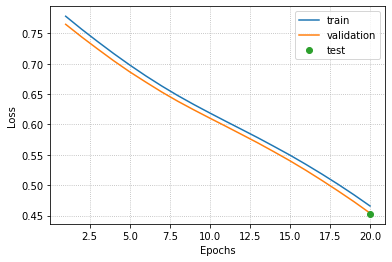

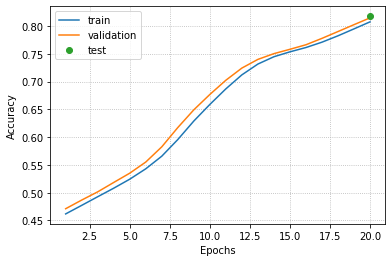

[20 20  7 20  7 20 20  7 20 20]
acc: 0.0036855036855036856


In [86]:
main(filename='adult', mask_mode='single', seed=42)

epoch 0, train_loss=0.6875673532485962, validation_loss=0.6769874619715142, train_acc=0.564585494614819, val_acc=0.5769917411823149
epoch 1, train_loss=0.6705764532089233, validation_loss=0.6606462886839202, train_acc=0.5849507082918811, val_acc=0.5982841441345541
epoch 2, train_loss=0.6542809903621674, validation_loss=0.6442030776630748, train_acc=0.6066747949017404, val_acc=0.6212054680292385
epoch 3, train_loss=0.638303816318512, validation_loss=0.6286454688418995, train_acc=0.6280810862638234, val_acc=0.6397667394081328
epoch 4, train_loss=0.6227798759937286, validation_loss=0.6132628177151536, train_acc=0.6438219091079488, val_acc=0.6514968552622242
epoch 5, train_loss=0.6075997203588486, validation_loss=0.5985468174472, train_acc=0.6564919043860028, val_acc=0.6644433947200341
epoch 6, train_loss=0.5927437245845795, validation_loss=0.5836990475654602, train_acc=0.6719602058912583, val_acc=0.6834138368462139
epoch 7, train_loss=0.5782689601182938, validation_loss=0.5691401741721414

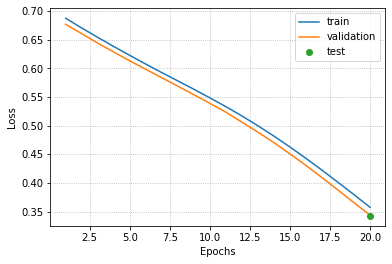

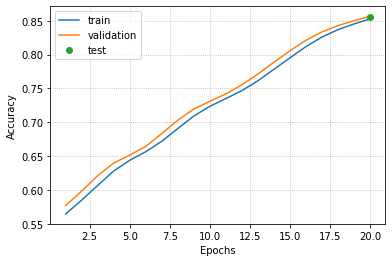

[ 0  3  3  3  3 12  3  3 12  3]
acc: 0.03521703521703522


In [87]:
main(filename='adult', mask_mode='single', seed=10)

epoch 0, train_loss=0.7452848553657532, validation_loss=0.733680526415507, train_acc=0.46393978653921014, val_acc=0.48019513785394946
epoch 1, train_loss=0.7270991504192352, validation_loss=0.7160913366259951, train_acc=0.4913918310336376, val_acc=0.5119197315662479
epoch 2, train_loss=0.7099378556013107, validation_loss=0.6994230783346927, train_acc=0.5249033515002091, val_acc=0.5479256484635582
epoch 3, train_loss=0.6934493780136108, validation_loss=0.6836471124128862, train_acc=0.5618468436855688, val_acc=0.5834497640337805
epoch 4, train_loss=0.6780054718255997, validation_loss=0.6688563317963572, train_acc=0.5955400547168996, val_acc=0.6121227645305517
epoch 5, train_loss=0.663652315735817, validation_loss=0.6551285620891687, train_acc=0.620590208090027, val_acc=0.6314790912639275
epoch 6, train_loss=0.6504207104444504, validation_loss=0.6425802472865942, train_acc=0.6383229214426807, val_acc=0.6483537807820594
epoch 7, train_loss=0.6380372494459152, validation_loss=0.630756804437

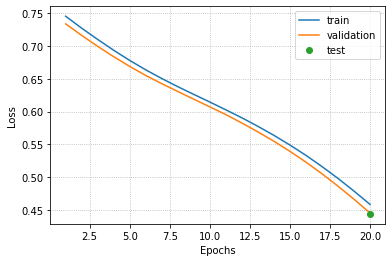

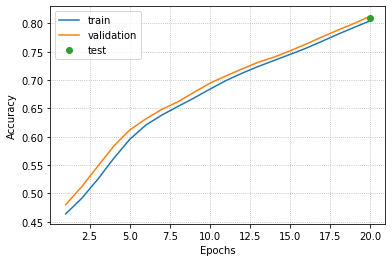

[ 3 18  3  3  3  3 18  3  3  3]
acc: 0.005323505323505323


In [88]:
main(filename='adult', mask_mode='single', seed=100)

epoch 0, train_loss=0.6991112530231476, validation_loss=0.6868868723060145, train_acc=0.5633530005983535, val_acc=0.5740765382158824
epoch 1, train_loss=0.6804757714271545, validation_loss=0.6690674984093868, train_acc=0.5813978888216043, val_acc=0.5949919274714357
epoch 2, train_loss=0.6625854969024658, validation_loss=0.6517099358818748, train_acc=0.6058588999668383, val_acc=0.6246168875523382
epoch 3, train_loss=0.645555391907692, validation_loss=0.6352684226903048, train_acc=0.6377143435413873, val_acc=0.6595444343907457
epoch 4, train_loss=0.6294843256473541, validation_loss=0.6196581305879535, train_acc=0.6707599584396673, val_acc=0.6873702629337874
epoch 5, train_loss=0.6140874624252319, validation_loss=0.6048358805251844, train_acc=0.6933862766195193, val_acc=0.7023460231708183
epoch 6, train_loss=0.5993371158838272, validation_loss=0.5904639399412906, train_acc=0.7067323188358782, val_acc=0.713860465013129
epoch 7, train_loss=0.5851480960845947, validation_loss=0.5765584671136

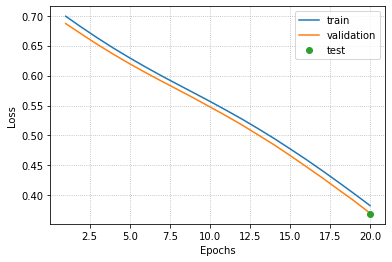

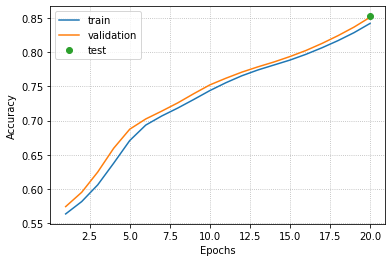

[1 1 1 1 1 1 1 1 1 1]
acc: 0.015561015561015561


In [89]:
main(filename='adult', mask_mode='single', seed=1000)

epoch 0, train_loss=0.7164344191551208, validation_loss=0.7038046410589507, train_acc=0.4813411169744943, val_acc=0.49452553935135907
epoch 1, train_loss=0.6960355043411255, validation_loss=0.683920661608378, train_acc=0.504776488494312, val_acc=0.5240956106734794
epoch 2, train_loss=0.6768674403429031, validation_loss=0.6651612104791583, train_acc=0.5376675333780296, val_acc=0.563303371833085
epoch 3, train_loss=0.6582207381725311, validation_loss=0.647100340236317, train_acc=0.580239164756261, val_acc=0.6086620005677383
epoch 4, train_loss=0.6407669186592102, validation_loss=0.6300722288362908, train_acc=0.622507848162406, val_acc=0.6442426681924633
epoch 5, train_loss=0.6242126226425171, validation_loss=0.6141054901209745, train_acc=0.6518754545323471, val_acc=0.6646086154282874
epoch 6, train_loss=0.6086561381816864, validation_loss=0.5995281862490105, train_acc=0.6697513817999626, val_acc=0.6783624077425308
epoch 7, train_loss=0.593838170170784, validation_loss=0.5850062189680157,

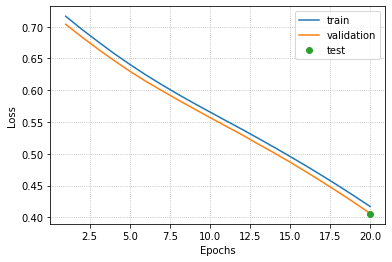

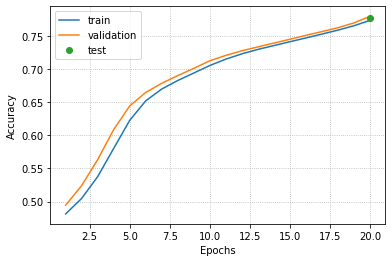

[23  4 23 10 23 23 23 23 23 23]
acc: 0.030303030303030304


In [90]:
main(filename='adult', mask_mode='single', seed=10000)

In [92]:
metrics = [0.03, 0.015, 0.005, 0.035, 0.036]
print(np.mean(metrics), np.std(metrics))


0.0242 0.012188519188154072


# DIFFERENT

epoch 0, train_loss=0.7717850208282471, validation_loss=0.765457115390084, train_acc=0.4669642934382975, val_acc=0.4729076848697751
epoch 1, train_loss=0.759588748216629, validation_loss=0.7532694989984686, train_acc=0.476566421197572, val_acc=0.48191942108438
epoch 2, train_loss=0.7487674653530121, validation_loss=0.7423190275828043, train_acc=0.48647496161166137, val_acc=0.4917367468596977
epoch 3, train_loss=0.7381113320589066, validation_loss=0.7315744811838324, train_acc=0.49602169607970353, val_acc=0.5025160119934711
epoch 4, train_loss=0.7282717227935791, validation_loss=0.7212795362328038, train_acc=0.5055876609426591, val_acc=0.5128062681853666
epoch 5, train_loss=0.7182776629924774, validation_loss=0.7119473471786036, train_acc=0.5153518840924493, val_acc=0.5225515178127883
epoch 6, train_loss=0.7089189887046814, validation_loss=0.703003881555615, train_acc=0.5263087547039231, val_acc=0.5343027020793416
epoch 7, train_loss=0.6998029351234436, validation_loss=0.693699556769746

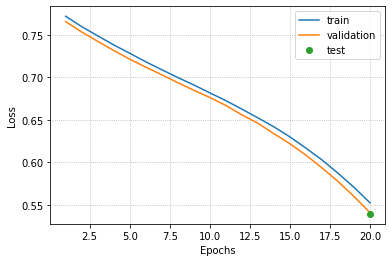

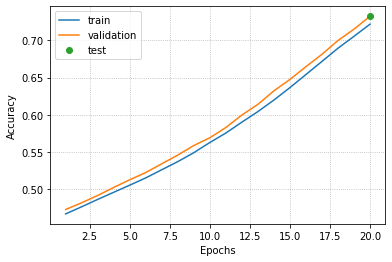

[2 1 2 2 2 5 2 5 1 1]
acc: 0.16066066066066065


In [81]:
main(filename='adult', mask_mode='different', seed=42)

epoch 0, train_loss=0.7544855624437332, validation_loss=0.7478849743351792, train_acc=0.49262957794454776, val_acc=0.49754663881200767
epoch 1, train_loss=0.7423991560935974, validation_loss=0.7358237920385419, train_acc=0.5044642045864153, val_acc=0.5107626321765667
epoch 2, train_loss=0.7308761328458786, validation_loss=0.7239359761729385, train_acc=0.5160936484421184, val_acc=0.5226457712369597
epoch 3, train_loss=0.7185557782649994, validation_loss=0.710458188345938, train_acc=0.530009677465865, val_acc=0.538141588602654
epoch 4, train_loss=0.7068778425455093, validation_loss=0.6991118301044811, train_acc=0.542867510669435, val_acc=0.5515216938116528
epoch 5, train_loss=0.6948045641183853, validation_loss=0.6869031245058234, train_acc=0.5570961660322679, val_acc=0.5657084974451777
epoch 6, train_loss=0.6825160980224609, validation_loss=0.6737607699452024, train_acc=0.5718599496085471, val_acc=0.5819938258462848
epoch 7, train_loss=0.6699224561452866, validation_loss=0.6608892299912

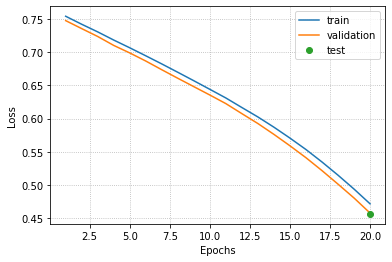

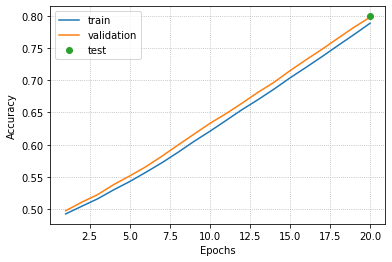

[ 1 32  4  1  1 32 32 32 32 32]
acc: 0.09937209937209937


In [94]:
main(filename='adult', mask_mode='different', seed=15)

epoch 0, train_loss=0.727424830198288, validation_loss=0.7226984789877227, train_acc=0.5229509251048922, val_acc=0.5280370670995672
epoch 1, train_loss=0.7176576256752014, validation_loss=0.7116938359809645, train_acc=0.5332441842568161, val_acc=0.5399678873039528
epoch 2, train_loss=0.707599014043808, validation_loss=0.7015857696533203, train_acc=0.544867928255259, val_acc=0.5517955831736568
epoch 3, train_loss=0.6977767795324326, validation_loss=0.6907219001741121, train_acc=0.5561331657222776, val_acc=0.5648729685614932
epoch 4, train_loss=0.687386080622673, validation_loss=0.6804429473298969, train_acc=0.5686229809175714, val_acc=0.5774724336455894
epoch 5, train_loss=0.6768104732036591, validation_loss=0.6693517023866827, train_acc=0.5822156114379227, val_acc=0.5913099451777729
epoch 6, train_loss=0.6653777211904526, validation_loss=0.6581021077705153, train_acc=0.5973942444526147, val_acc=0.6074793973103398
epoch 7, train_loss=0.6544084250926971, validation_loss=0.645767336541956

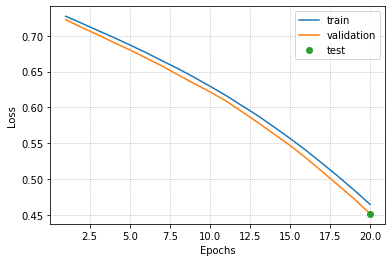

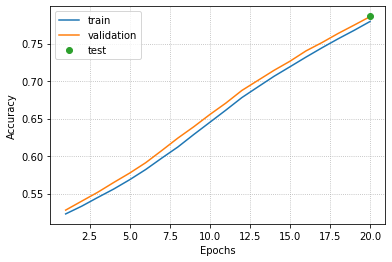

[0 2 3 0 0 2 2 3 2 2]
acc: 0.11425061425061425


In [83]:
main(filename='adult', mask_mode='different', seed=100)

epoch 0, train_loss=0.7362449169158936, validation_loss=0.728746235370636, train_acc=0.5133961344925531, val_acc=0.5219255641899084
epoch 1, train_loss=0.7243435829877853, validation_loss=0.7171333703127775, train_acc=0.5269276760096313, val_acc=0.5357453339010715
epoch 2, train_loss=0.7123620361089706, validation_loss=0.7041368917985396, train_acc=0.5422689416713526, val_acc=0.5535082233340431
epoch 3, train_loss=0.700600191950798, validation_loss=0.6924715132424326, train_acc=0.5574677514526292, val_acc=0.5684562619757292
epoch 4, train_loss=0.6884450316429138, validation_loss=0.6822335485256079, train_acc=0.5749326508139049, val_acc=0.5845170454545455
epoch 5, train_loss=0.6761346757411957, validation_loss=0.6700520840558138, train_acc=0.5926045601020805, val_acc=0.6012669877936272
epoch 6, train_loss=0.6644080132246017, validation_loss=0.6570954702117227, train_acc=0.610099337846216, val_acc=0.6202368754879
epoch 7, train_loss=0.6515949964523315, validation_loss=0.6441454544211879,

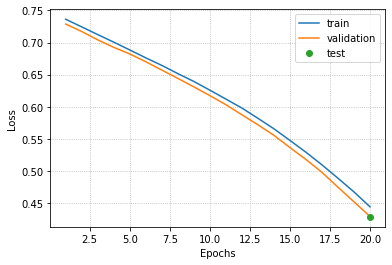

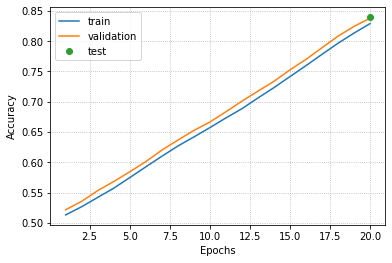

[41  0  0 41 41  0  0  0  0  0]
acc: 0.04695604695604696


In [84]:
main(filename='adult', mask_mode='different', seed=1000)

epoch 0, train_loss=0.7485108971595764, validation_loss=0.7426773363893683, train_acc=0.49434679862883346, val_acc=0.5012702034986871
epoch 1, train_loss=0.738042414188385, validation_loss=0.7306533744840911, train_acc=0.5066195571463586, val_acc=0.5157026204669648
epoch 2, train_loss=0.7278566807508469, validation_loss=0.7209106828227188, train_acc=0.519103596248396, val_acc=0.5278590944574552
epoch 3, train_loss=0.7171638011932373, validation_loss=0.7104988495508829, train_acc=0.5328688046988769, val_acc=0.5414753876587893
epoch 4, train_loss=0.7061437368392944, validation_loss=0.6999739336244988, train_acc=0.547741049749845, val_acc=0.5555890062806046
epoch 5, train_loss=0.6953537911176682, validation_loss=0.6893058274731492, train_acc=0.5624105241720374, val_acc=0.5709578587396209
epoch 6, train_loss=0.6841816157102585, validation_loss=0.6768470840020613, train_acc=0.5776952124515189, val_acc=0.5876285173160173
epoch 7, train_loss=0.6726040244102478, validation_loss=0.6651575095725

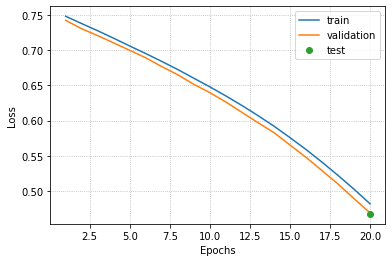

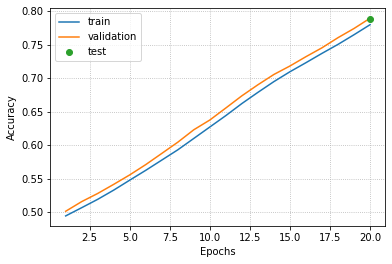

[24 38 24  4  4 24 38 24 24 24]
acc: 0.12694512694512694


In [85]:
main(filename='adult', mask_mode='different', seed=10000)

In [95]:
metrics = [0.126, 0.046, 0.1142, 0.1, 0.16]
print(np.mean(metrics), np.std(metrics))

0.10924 0.03732760908496551
